# COVID-19 Forecast Using DARTS for Univariate and Multivariate Time-Series Forecasting
## DS 440 

In [1]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import seaborn as sns
from darts import TimeSeries
from darts.models import *
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.metrics import mape, smape



# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in dataset
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [3]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
# Quantify rows and columns
df.shape

(170654, 67)

In [5]:
# List of columns
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

# Create different simple models for predicting number of cases for one region (I'm choosing USA)

In [6]:
# Subset data for only US data
df_us = df.loc[df['location'] == 'United States']

In [33]:
col_list = df_us.columns
for col in col_list:
    print(df_us[col].isna().sum())

0
0
0
0
0
1
7
38
39
51
0
1
7
38
39
51
47
177
177
177
177
792
792
183
183
47
47
47
47
54
54
53
53
47
327
327
327
570
328
328
327
327
327
570
328
328
328
7
0
0
0
0
0
0
0
0
0
0
0
792
0
0
0
685
685
685
685


In [7]:
df_us.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
161316,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
161317,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
161318,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
161319,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
161320,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8926.0,-3.59,-2.63,-26.811643


In [8]:
# Subset for only the dates and total_cases columns

df_us_cases = df_us[['date', 'total_cases']]
df_us_deaths = df_us[['date', 'total_deaths']]
df_us_cases.head()

,date,total_cases
161316,2020-01-22,1.0
161317,2020-01-23,1.0
161318,2020-01-24,2.0
161319,2020-01-25,2.0
161320,2020-01-26,5.0


In [9]:
df_us_cases = df_us_cases.dropna()
df_us_deaths = df_us_deaths.dropna()
print(df_us_cases['total_cases'].isnull().sum())
print(df_us_cases['total_cases'].isna().sum())
print(df_us_deaths['total_deaths'].isnull().sum())
print(df_us_deaths['total_deaths'].isna().sum())

0
0
0
0


In [10]:
df_us_cases.tail()

,date,total_cases
162103,2022-03-19,79728165.0
162104,2022-03-20,79734788.0
162105,2022-03-21,79780432.0
162106,2022-03-22,79803443.0
162107,2022-03-23,79844430.0


In [11]:
# Need to set the date col to be a df index and format the date column to a date type
df_us_cases.index = pd.to_datetime(df_us_cases['date'], format='%Y-%m-%d')
df_us_deaths.index = pd.to_datetime(df_us_deaths['date'], format='%Y-%m-%d')

In [12]:
# Split the data into a training and testing set
# Training will be all data before December 2021 and Testing will be all data since then
train_cases = df_us_cases[df_us_cases.index < pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
test_cases = df_us_cases[df_us_cases.index >= pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
train_deaths = df_us_deaths[df_us_deaths.index < pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
test_deaths = df_us_deaths[df_us_deaths.index >= pd.to_datetime('2021-12-01', format='%Y-%m-%d')]


In [13]:
train_cases.reset_index(drop=True, inplace=True)
test_cases.reset_index(drop=True, inplace=True)
train_deaths.reset_index(drop=True, inplace=True)
test_deaths.reset_index(drop=True, inplace=True)

In [14]:
cases_series = TimeSeries.from_dataframe(df_us_cases, 'date', 'total_cases')
train_cases_series = TimeSeries.from_dataframe(train_cases, 'date', 'total_cases')
test_cases_series = TimeSeries.from_dataframe(test_cases, 'date', 'total_cases')
deaths_series = TimeSeries.from_dataframe(df_us_deaths, 'date', 'total_deaths')
train_deaths_series = TimeSeries.from_dataframe(train_deaths, 'date', 'total_deaths')
test_deaths_series = TimeSeries.from_dataframe(test_deaths, 'date', 'total_deaths')

# Just using a simple Exponential Smoothing Model for Univariate

In [20]:
model = ExponentialSmoothing()
model.fit(train_cases_series)
prediction = model.predict(len(test_cases_series)+90, num_samples=1000)

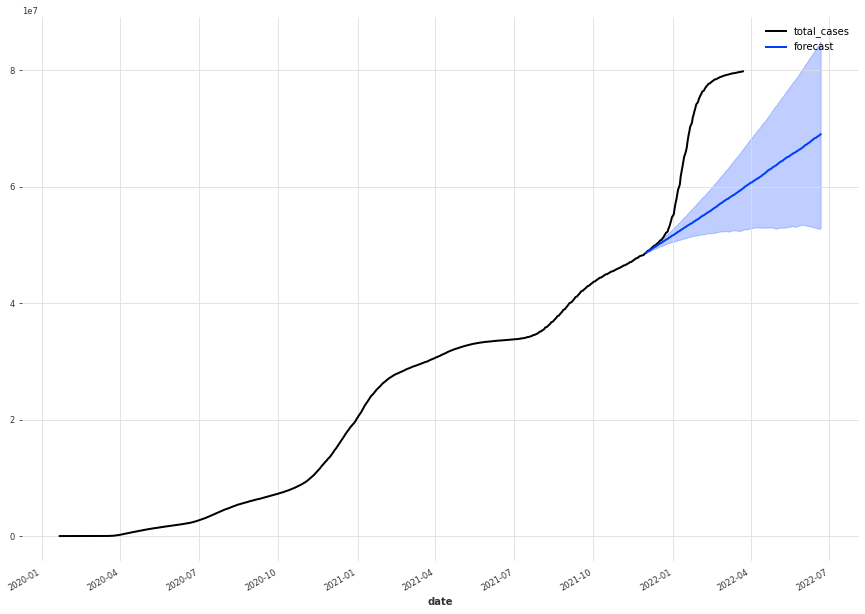

In [21]:
cases_series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]

In [17]:
model = ExponentialSmoothing()
model.fit(train_deaths_series)
prediction = model.predict(len(test_deaths_series)+60, num_samples=1000)

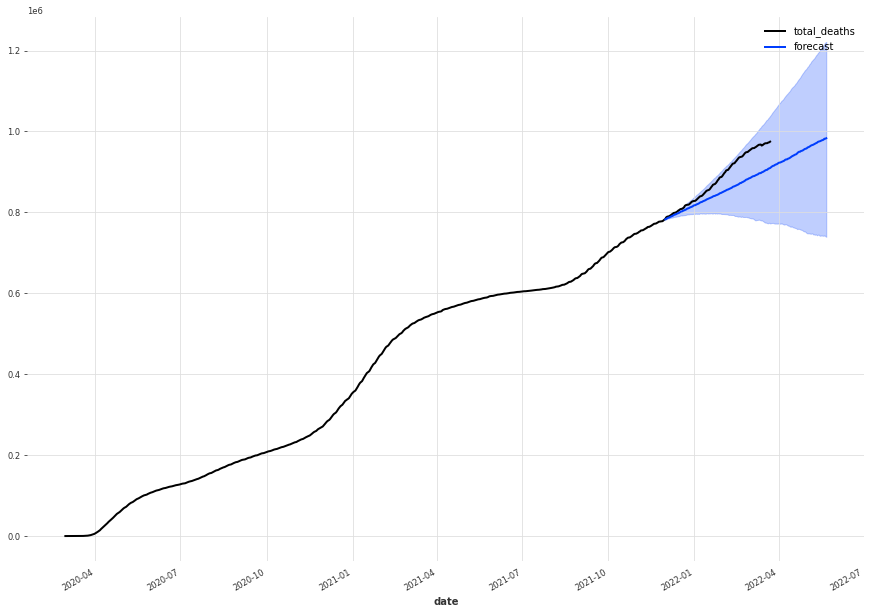

In [18]:
deaths_series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]

# Attempting Multivariate Time Series Modeling Using additional variables 'Total Vaccinations' and 'Total Boosters'

In [15]:
# Subset for variables wanted for multivariate time series modeling

df_us_cases = df_us[['date', 'total_cases']]
df_us_vacc = df_us[['date', 'total_vaccinations']]
df_us_boosters = df_us[['date', 'total_boosters']]
df_us_deaths = df_us[['date', 'total_deaths']]

In [16]:
# replace na values with 0
df_us_boosters['total_boosters'] = df_us_boosters['total_boosters'].fillna(0)
df_us_vacc['total_vaccinations'] = df_us_vacc['total_vaccinations'].fillna(0)

In [17]:
booster_series = TimeSeries.from_dataframe(df_us_boosters, 'date', 'total_boosters')
vaccine_series = TimeSeries.from_dataframe(df_us_vacc, 'date', 'total_vaccinations')
cases_series = TimeSeries.from_dataframe(df_us_cases, 'date', 'total_cases')
deaths_series = TimeSeries.from_dataframe(df_us_deaths, 'date', 'total_deaths')

In [18]:
scaler_cases, scaler_deaths, scaler_boosters, scaler_vaccine = Scaler(), Scaler(), Scaler(), Scaler()
series_cases_scaled = scaler_cases.fit_transform(cases_series)
series_deaths_scaled = scaler_deaths.fit_transform(deaths_series)
series_boosters_scaled = scaler_boosters.fit_transform(booster_series)
series_vaccines_scaled = scaler_vaccine.fit_transform(vaccine_series)


In [19]:
train_cases, val_cases = series_cases_scaled[:-36], series_cases_scaled[-36:]
train_deaths, val_deaths = series_deaths_scaled[:-36], series_deaths_scaled[-36:]
train_boosters, val_boosters = series_boosters_scaled[:-36], series_boosters_scaled[-36:]
train_vaccines, val_vaccines = series_vaccines_scaled[:-36], series_vaccines_scaled[-36:]

In [43]:
model_cases_vaccines = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100)

In [44]:
model_cases_vaccines.fit([train_cases, train_vaccines], verbose=True)

[2022-03-24 13:17:52,068] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1442 samples.
[2022-03-24 13:17:52,068] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1442 samples.
[2022-03-24 13:17:52,225] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-24 13:17:52,225] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-24 13:17:52,230] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-24 13:17:52,230] WARNING | darts.models.forecasting.torch_forecasting_model | Depre

Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

MAPE = 1.07%


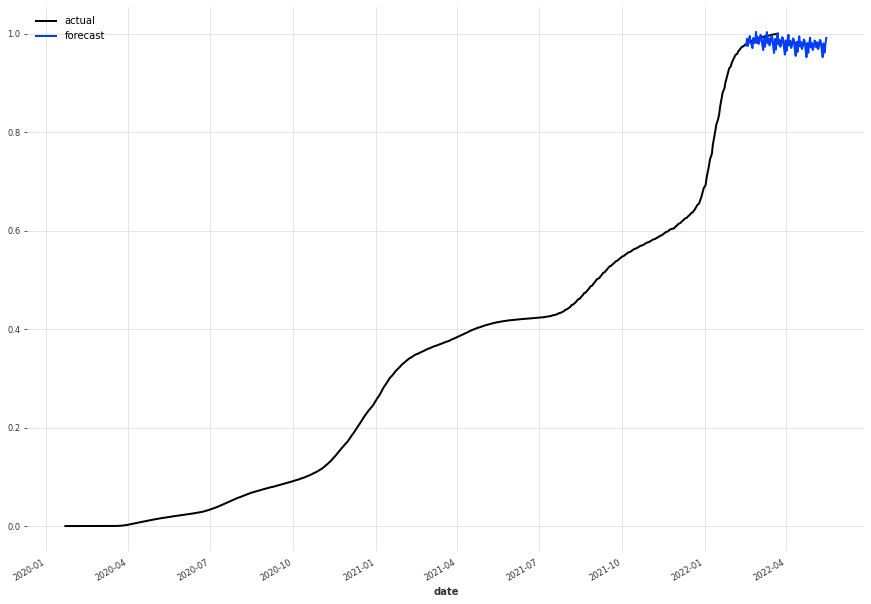

In [50]:
pred = model_cases_vaccines.predict(n=90, series=train_cases)

series_cases_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_cases_scaled, pred)))

In [20]:
model_cases = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100)
model_cases.fit(train_cases, verbose=True)

[2022-03-24 15:19:20,926] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 721 samples.
[2022-03-24 15:19:20,926] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 721 samples.
[2022-03-24 15:19:21,001] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-24 15:19:21,001] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-24 15:19:21,002] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-24 15:19:21,002] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

MAPE = 1.05%


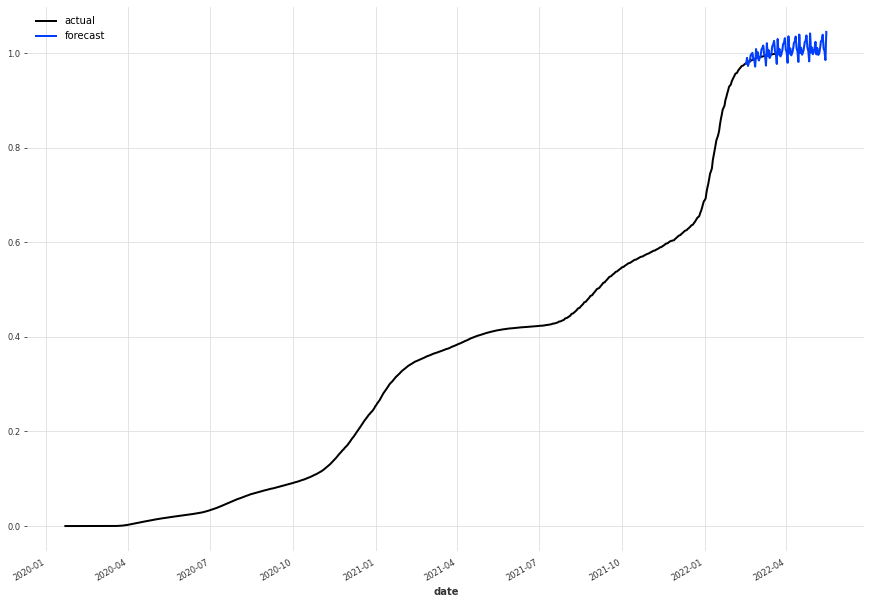

In [39]:
pred = model_cases.predict(n=90, series=train_cases, num_samples=1000)

series_cases_scaled.plot(label='actual')
pred.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend();
plt.rcParams['figure.figsize'] = [15, 10]
print('MAPE = {:.2f}%'.format(mape(series_cases_scaled, pred)))